In [21]:
# imports and settings
import os
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import MDAnalysis as mda
import seaborn as sns
import nglview as nv                            # for visualisation
from MDAnalysis.analysis.align import alignto   # for aligning structures
from MDAnalysis.analysis.pca import PCA         # for PCA
from Bio.PDB import PDBParser
from Bio.PDB.DSSP import DSSP                   # for secondary structure selection
from Bio.PDB.SASA import ShrakeRupley           # for SASA calculation
from IPython.display import display             # for data frame display
from multiprocessing import Pool                # for multiprocessing
from tqdm import tqdm                           # for progress bars

# surpress warnings
warnings.filterwarnings(action='ignore', module='matplotlib')
warnings.filterwarnings(action='ignore', module='mdanalysis')

# pandas settings
pd.set_option('display.max_colwidth', None)

############################################################################################################

# base directories
base_directory = "/biggin/b212/bioc1781/Projects/KDELR/red-msa/" #"/biggin/b212/bioc1781/Projects/CTNS/human/monomer/red-msa/with-dropout/"
structure_directory = base_directory + "ensemble/" # directory with the AF2 ensemble, cannot be the same as base directory

# settings
selection_for_writeout  = "protein and name CA"  # useful if you want all the outputs to have a specific selection
conserved_residues      = "resid 12 or resid 169" #'resid 205 or resid 305 or resid 346 or resid 169 or resid 308 or resid 339 or resid 260 or resid 158 or resid 338 or resid 177 or resid 288 or resid 222 or resid 139 or resid 141 or resid 298 or resid 182 or resid 280 or resid 335 or resid 142 or resid 138 or resid 170 or resid 208 or resid 173 or resid 134'
resid_offset    = 0 #115               # first resID in the reference structures if the chain does not start from 1
# structure filtering   
thresh_rmsd     = 10 #6               # threshold for discarding structures based on RMSD
thresh_pLDDT    = 80                # threshold for discarding structures based on pLDDT
thresh_sasa_coeff = 100             # multiple of highest sasa of the reference structure above which structures are discarded
diffmat_thresh  = 0                 # threshold for ignoring atoms in RMSD calculations based on how much they differ between the reference structures
# analysis  
num_processes   = 12                # CPU cores to use for multiprocessing
n_pcs           = 3                 # number of principal components to keep in PCA
# monte carlo   
mc_temp         = 500               # monte carlo temperature
mc_wf_sasa      = 0                  # monte carlo energy function weight factor for SASA (check if this should be -ve, depends on order of subtraction and matrix indexing)
mc_n_runs       = 1             # number of monte carlo runs
mc_n_bins       = 16                # so mc_n_bins is the total number of bins (because of reference structures and zero indexing)
collective_variable = 'PC1'         # collective_variable to bin for path finding
start_from_endstates = False
# for plotting
plot_variable_1     = 'PC1'   
plot_variable_2     = 'PC2'
plot_variable_3     = 'sasa'

os.environ["OMP_NUM_THREADS"] = str(num_processes)

############################################################################################################

# reference structures
use_reference_structures = False
if use_reference_structures:
    outward_open_pdb = base_directory + "8DKE_cytosol_noNTD_hydrogens.pdb"
    inward_open_pdb  = base_directory + "8DKI_lumen_noNTD_hydrogens.pdb"

    # universes for reference structures
    u_outward_open = mda.Universe(outward_open_pdb, outward_open_pdb)
    u_inward_open  = mda.Universe(inward_open_pdb, inward_open_pdb)

    # align reference structures to eachother
    alignto(u_inward_open, u_outward_open, select='name CA', weights="mass")

    # write reindexed pdbs of reference structures for inclusion in the ensemble
    u_outward_open.atoms.residues.resids -= resid_offset
    u_outward_open.atoms.write(structure_directory + "ref_outward.pdb")
    u_outward_open.atoms.residues.resids += resid_offset
    #
    u_inward_open.atoms.residues.resids -= resid_offset
    u_inward_open.atoms.write(structure_directory + "ref_inward.pdb")
    u_inward_open.atoms.residues.resids += resid_offset

else:

    outward_open_pdb = None
    inward_open_pdb  = None



In [8]:
# retrieve structures

# user specific - do whatever you need here to get a dictionary of structures and their associated pLDDT values

# # ONLY NEED TO RUN ONCE 
# # copy structures from outputs to ensemble
# msa_depths = ['8-16', '16-32']
# 
# for msa in msa_depths:
#     structures_msa = [f for f in os.listdir(base_directory + 'output_' + msa) if f.endswith('.pdb')]
#     for structure in structures_msa:
#         # copy all the pdb files with "_relaxed_" in the name to the structure directory
#         if "_relaxed_" in structure:
#             # get the rank of the strcuture (last thing before the file extension)
#             rank = 'rank_' + structure.split('_')[structure.split('_').index('rank')+1]
#             os.system('cp ' + base_directory + 'output_' + msa + '/' + structure + ' ' + structure_directory + '/msa-' + msa + '_' + rank + '.pdb')

# get list of all files in structure directory directory with the pdb extension
structures = [f for f in os.listdir(structure_directory) if f.endswith('.pdb')]
structures.sort()

# associate structures with pLDDT values
structure_and_pLDDT = {}

msa_depths = ['8-16', '16-32']
for msa in msa_depths:
    structures_msa = [f for f in os.listdir(structure_directory) if f.endswith('.pdb') and msa in f and str(msa) in f]
    log_file = structure_directory + msa + "_log.txt"   # look up the corresponding log file
    for structure in structures_msa:
        rank = 'rank_' + structure.split('_')[structure.split('_').index('rank')+1] # get the rank of the structure
        rank = rank.split('.')[0]           # remove the file extension
        with open(log_file, "r") as file:
            for line in file:               # match the rank with the pLDDT value
                if rank in line:
                    pLDDT = line.split()[3].replace('pLDDT=','')
                    structure_and_pLDDT[structure] = float(pLDDT)
                    break

print('Structures:', len(structure_and_pLDDT))

# if no reference structures, chose 2 hightest pLDDT structures as references
if not use_reference_structures:
    # get the 2 structures with the highest pLDDT values
    ref_structures = sorted(structure_and_pLDDT, key=structure_and_pLDDT.get, reverse=True)[:2]
    print('Reference structures:', ref_structures)
    # declare the appropriate variable (the name of the structure file)
    outward_open_pdb = structure_directory + ref_structures[0]
    inward_open_pdb  = structure_directory + ref_structures[1]
    # universes for reference structures
    u_outward_open = mda.Universe(outward_open_pdb, outward_open_pdb)
    u_inward_open  = mda.Universe(inward_open_pdb, inward_open_pdb)

    # align reference structures to eachother
    alignto(u_inward_open, u_outward_open, select='name CA', weights="mass")

    # write reindexed pdbs of reference structures for inclusion in the ensemble
    u_outward_open.atoms.residues.resids -= resid_offset
    u_outward_open.atoms.write(structure_directory + "ref_outward.pdb")
    u_outward_open.atoms.residues.resids += resid_offset
    #
    u_inward_open.atoms.residues.resids -= resid_offset
    u_inward_open.atoms.write(structure_directory + "ref_inward.pdb")
    u_inward_open.atoms.residues.resids += resid_offset


Structures: 4000
Reference structures: ['msa-16-32_rank_001.pdb', 'msa-16-32_rank_002.pdb']


/biggin/b212/bioc1781/.local/lib/python3.10/site-packages/MDAnalysis/coordinates/PDB.py:775: UserWarning: Unit cell dimensions not found. CRYST1 record set to unitary values.
  warnings.warn("Unit cell dimensions not found. "
/biggin/b212/bioc1781/.local/lib/python3.10/site-packages/MDAnalysis/coordinates/PDB.py:1151: UserWarning: Found no information for attr: 'formalcharges' Using default value of '0'
  warnings.warn("Found no information for attr: '{}'"


In [9]:
# automatic "clever" selection definer

# temporary universe
u = u_outward_open

# identify regions of secondary structure
p = PDBParser()
structure = p.get_structure('reference', outward_open_pdb)
model = structure[0]
dssp = DSSP(model, outward_open_pdb, dssp='mkdssp')

helices = []
sheets  = []
loops   = []

# get secondary structure labels for resIDs
for key in dssp.keys():
    if dssp[key][2] == 'H' or dssp[key][2] == 'G' or dssp[key][2] == 'I':
        helices.append(key[1][1])
    elif dssp[key][2] == 'E':
        sheets.append(key[1][1])
    elif dssp[key][2] == 'T' or dssp[key][2] == 'S':
        loops.append(key[1][1])
    
helices = sorted(list(set(helices)))
sheets = sorted(list(set(sheets)))
loops = sorted(list(set(loops)))

helices_contiguous = []
sheets_contiguous  = []
loops_contiguous   = []

# get contiguous regions of secondary structure
for i in range(len(helices)):
    if i == 0:
        helices_contiguous.append([helices[i]])
    elif helices[i] == helices[i-1] + 1:
        helices_contiguous[-1].append(helices[i])
    else:
        helices_contiguous.append([helices[i]])

for i in range(len(sheets)):
    if i == 0:
        sheets_contiguous.append([sheets[i]])
    elif sheets[i] == sheets[i-1] + 1:
        sheets_contiguous[-1].append(sheets[i])
    else:
        sheets_contiguous.append([sheets[i]])

for i in range(len(loops)):
    if i == 0:
        loops_contiguous.append([loops[i]])
    elif loops[i] == loops[i-1] + 1:
        loops_contiguous[-1].append(loops[i])
    else:
        loops_contiguous.append([loops[i]])

selection_helices = []
selection_sheets  = []
selection_loops   = []

# make mdanalysis selections corresponding to these regions
for i in range(len(helices_contiguous)):
    selection_helices.append('(resid %s-%s and (name CA))' % (helices_contiguous[i][0], helices_contiguous[i][-1]))
for i in range(len(sheets_contiguous)):
    selection_sheets.append('(resid %s-%s and (name CA))' % (sheets_contiguous[i][0], sheets_contiguous[i][-1]))
for i in range(len(loops_contiguous)):
    selection_loops.append('(resid %s-%s and (name CA))' % (loops_contiguous[i][0], loops_contiguous[i][-1]))

# conserved residues
selection_conserved_residues = '(' + conserved_residues + ') and (name CA or name CG or name CZ* or name NZ)' 

# format selections
selection_helices = ','.join(selection_helices)
selection_helices = selection_helices.replace(',', ' or ')
selection_sheets = ','.join(selection_sheets)
selection_sheets = selection_sheets.replace(',', ' or ')
selection_loops = ','.join(selection_loops)
selection_loops = selection_loops.replace(',', ' or ')

endstates = {}

# trying to be clever and getting rmsd_selection for which to compare rmsd by comparing the distance matrices of the two end states
for end_state in [u_outward_open, u_inward_open]:
    u = end_state.select_atoms('name CA')
    distance_matrix = []
    for i in u.atoms:
        for j in u.atoms:
                distance_matrix.append(np.linalg.norm(i.position - j.position)) # append distance between atoms to distance array
    
    # reshape to a square matrix and append to dictionary
    distance_matrix = np.array(distance_matrix).reshape((len(u.atoms),len(u.atoms)))
    endstates[end_state] = distance_matrix

# subtract the distance matrices to get the difference matrix
ca_dist_difference_matrix = endstates[u_outward_open] - endstates[u_inward_open]

resids_from_ca_dist_diffmat = []

# get the resid of the residues that differ by more than the threshold in absolute terms
above_thresh = np.where(abs(ca_dist_difference_matrix) >= diffmat_thresh)
for i in range(len(above_thresh[0])):
    resids_from_ca_dist_diffmat.append(u.atoms[above_thresh[0][i]].resid)
resids_from_ca_dist_diffmat = list(set(resids_from_ca_dist_diffmat))    # get unique residues

# make a selection token for these residues
selection_from_ca_dist_diffmat = []
for i in range(len(resids_from_ca_dist_diffmat)):
    selection_from_ca_dist_diffmat.append('resid %s' % resids_from_ca_dist_diffmat[i])
selection_from_ca_dist_diffmat = ','.join(selection_from_ca_dist_diffmat)
selection_from_ca_dist_diffmat = selection_from_ca_dist_diffmat.replace(',', ' or ')

# final rmsd_selection for analysis
rmsd_selection = '(((' + selection_helices + ') or (' + selection_loops + ')) and (' + selection_from_ca_dist_diffmat + ')) or' + selection_conserved_residues #+ ' and not (resid 116-120 or resid 356-367)'

# show the clipped difference matrix
#ca_dist_difference_matrix[np.where(abs(ca_dist_difference_matrix) < diffmat_thresh)] = 0
#plt.imshow(ca_dist_difference_matrix)
#plt.colorbar()

# show the selection using nglview
rmsd_selection_atoms = u_outward_open.select_atoms(rmsd_selection)
view = nv.show_mdanalysis(rmsd_selection_atoms)
view.add_licorice(selection=rmsd_selection, color='red')
view.center()
#view

print(rmsd_selection)

# write a pdb of the selection
# select the rmsd_selection atoms in the outward open structure
check = u.select_atoms(rmsd_selection)
# write out the selection
check.write(base_directory + 'rmsd_selection.pdb')




((((resid 3-26 and (name CA)) or (resid 34-47 and (name CA)) or (resid 49-52 and (name CA)) or (resid 58-81 and (name CA)) or (resid 83-85 and (name CA)) or (resid 96-108 and (name CA)) or (resid 115-129 and (name CA)) or (resid 132-141 and (name CA)) or (resid 146-173 and (name CA)) or (resid 178-200 and (name CA)) or (resid 202-204 and (name CA))) or ((resid 30-31 and (name CA)) or (resid 48-48 and (name CA)) or (resid 53-53 and (name CA)) or (resid 82-82 and (name CA)) or (resid 88-90 and (name CA)) or (resid 95-95 and (name CA)) or (resid 109-109 and (name CA)) or (resid 111-112 and (name CA)) or (resid 130-131 and (name CA)) or (resid 142-142 and (name CA)) or (resid 201-201 and (name CA)) or (resid 205-205 and (name CA)))) and (resid 1 or resid 2 or resid 3 or resid 4 or resid 5 or resid 6 or resid 7 or resid 8 or resid 9 or resid 10 or resid 11 or resid 12 or resid 13 or resid 14 or resid 15 or resid 16 or resid 17 or resid 18 or resid 19 or resid 20 or resid 21 or resid 22 or r

/biggin/b212/bioc1781/.local/lib/python3.10/site-packages/MDAnalysis/coordinates/PDB.py:775: UserWarning: Unit cell dimensions not found. CRYST1 record set to unitary values.
  warnings.warn("Unit cell dimensions not found. "
/biggin/b212/bioc1781/.local/lib/python3.10/site-packages/MDAnalysis/coordinates/PDB.py:1151: UserWarning: Found no information for attr: 'formalcharges' Using default value of '0'
  warnings.warn("Found no information for attr: '{}'"


In [ ]:
# if no reference states used, run PCA on the ensemble to get reference states



In [10]:
# calculate RMSDs of all the structures relative to the reference structures

# get average positions and make new universe with these positions
average_positions = (u_outward_open.atoms.positions + u_inward_open.atoms.positions) / 2
u_average = mda.Universe(outward_open_pdb, outward_open_pdb)
u_average.atoms.positions = average_positions

# define function to get rmsd to a structure
def get_rmsd_to_structure(structure):
    mobile = mda.Universe(structure_directory + structure, structure_directory + structure) # make universe
    mobile.atoms.residues.resids += resid_offset                                            # renumber residues in mobile
    rmsds = alignto(mobile, ref, select=rmsd_selection, match_atoms=True, weights=None)     # these ref selections are different becasue ref has different residue numbering
    return [structure, rmsds[1]]                                                            # [1] = rmsd after alignment

# define a function to calculate the SASA of a structure
def get_sasa(structure):
    p = PDBParser(QUIET=1)
    struct = p.get_structure(structure, structure_directory + structure)
    sr = ShrakeRupley(probe_radius=1.4, n_points=100)
    sr.compute(struct, level="S")
    return [structure, struct.sasa]  

rmsd_to_outward = {}

# outward open
ref = u_outward_open
with Pool(processes=num_processes) as pool:
    rmsds = list(tqdm(pool.imap(get_rmsd_to_structure, structures), total=len(structures)))
rmsd_to_outward = dict(rmsds)   # make this list of tuples into a dictionary

rmsd_to_inward = {}

# inward open
ref = u_inward_open
with Pool(processes=num_processes) as pool:
    rmsds = list(tqdm(pool.imap(get_rmsd_to_structure, structures), total=len(structures)))
rmsd_to_inward = dict(rmsds)   # make this list of tuples into a dictionary

rmsd_to_average = {}

# average
ref = u_average
with Pool(processes=num_processes) as pool:
    rmsds = list(tqdm(pool.imap(get_rmsd_to_structure, structures), total=len(structures)))
rmsd_to_average = dict(rmsds)   # make this list of tuples into a dictionary

sasa_dict = {}

# solvent accesible surface areas
with Pool(processes=num_processes) as pool:
    sasas = list(tqdm(pool.imap(get_sasa, structures), total=len(structures)))
sasa_dict = dict(sasas)         # make this list of tuples into a dictionary


100%|█████████▉| 3983/4002 [00:30<00:00, 139.24it/s]/biggin/b212/bioc1781/.local/lib/python3.10/site-packages/MDAnalysis/coordinates/PDB.py:451: UserWarning: 1 A^3 CRYST1 record, this is usually a placeholder. Unit cell dimensions will be set to None.
  warnings.warn("1 A^3 CRYST1 record,"
/biggin/b212/bioc1781/.local/lib/python3.10/site-packages/MDAnalysis/coordinates/PDB.py:451: UserWarning: 1 A^3 CRYST1 record, this is usually a placeholder. Unit cell dimensions will be set to None.
  warnings.warn("1 A^3 CRYST1 record,"
 99%|█████████▉| 3971/4002 [00:30<00:00, 110.89it/s]/biggin/b212/bioc1781/.local/lib/python3.10/site-packages/MDAnalysis/coordinates/PDB.py:451: UserWarning: 1 A^3 CRYST1 record, this is usually a placeholder. Unit cell dimensions will be set to None.
  warnings.warn("1 A^3 CRYST1 record,"
/biggin/b212/bioc1781/.local/lib/python3.10/site-packages/MDAnalysis/coordinates/PDB.py:451: UserWarning: 1 A^3 CRYST1 record, this is usually a placeholder. Unit cell dimensions 

In [15]:
# make big pandas dataframe and filter data
ensemble_df = pd.DataFrame.from_dict(rmsd_to_outward, orient='index', columns=['rmsd_to_outward'])
ensemble_df['rmsd_to_inward'] = rmsd_to_inward.values()
ensemble_df['rmsd_to_average'] = rmsd_to_average.values()

# rename the index column to structure
ensemble_df.index.names = ['structure']

# take square root of sasa so values are in ansgroms (rather than square angstroms)
ensemble_df['sasa'] = sasa_dict.values()
ensemble_df['sasa'] = ensemble_df['sasa'].apply(np.sqrt)
ensemble_df['sasa_negative'] = ensemble_df['sasa'] * -1

# additional quantities
ensemble_df['rmsd_sum']    = ensemble_df['rmsd_to_outward'] + ensemble_df['rmsd_to_inward']
ensemble_df['rmsd_mean']   = ensemble_df['rmsd_sum'] / 2
ensemble_df['rmsd_ratio_outwardness'] = 1 - (ensemble_df['rmsd_to_outward'] / ensemble_df['rmsd_sum'])
ensemble_df['rmsd_ratio_inwardness']  = 1 - (ensemble_df['rmsd_to_inward'] / ensemble_df['rmsd_sum'])

pLDDT_scores = {}
# Convert the dictionary to a DataFrame
plddt_df = pd.DataFrame(list(structure_and_pLDDT.items()), columns=['structure', 'pDDLDT'])
# add entries to dictionary for the reference structures with pLDDT scores of 100
plddt_df = pd.concat([plddt_df, pd.DataFrame({'structure': 'ref_outward.pdb', 'pDDLDT': 100}, index=[0])], ignore_index=True)   # append is deprecated, use concat instead
plddt_df = pd.concat([plddt_df, pd.DataFrame({'structure': 'ref_inward.pdb', 'pDDLDT': 100}, index=[0])], ignore_index=True)

# Merge the two DataFrames on the structure column
ensemble_df = pd.merge(ensemble_df, plddt_df, on='structure')

# set sasa threshold to the maximum of the reference structures
thresh_sasa = ensemble_df.loc[ensemble_df['structure'].isin(['ref_outward.pdb', 'ref_inward.pdb']), 'sasa'].max() * thresh_sasa_coeff    # occluded state should not be more exposed than the reference structures

print('SASA threshold:', thresh_sasa)

df_backup = ensemble_df # backup
ensemble_df = df_backup # reset

# trim all entries with rmsd_mean > thesh # discard junk
ensemble_df = ensemble_df[ensemble_df['rmsd_mean'] < thresh_rmsd]    # discard > thresh_rmsd
ensemble_df = ensemble_df[ensemble_df['pDDLDT'] > thresh_pLDDT]      # discard < thresh_pLDDT
ensemble_df = ensemble_df[ensemble_df['sasa'] <= thresh_sasa]                                               # discard < thresh_sasa

display(ensemble_df)

SASA threshold: 10504.5566974847


,structure,rmsd_to_outward,rmsd_to_inward,rmsd_to_average,sasa,sasa_negative,rmsd_sum,rmsd_mean,rmsd_ratio_outwardness,rmsd_ratio_inwardness,pDDLDT
0,msa-16-32_rank_001.pdb,0.000000,3.601342e-01,0.180058,104.066977,-104.066977,0.360134,0.180067,1.000000,0.000000,91.9
1,msa-16-32_rank_002.pdb,0.360134,6.945386e-07,0.180078,105.067540,-105.067540,0.360135,0.180067,0.000002,0.999998,91.2
2,msa-16-32_rank_003.pdb,0.736924,7.076452e-01,0.699742,105.478580,-105.478580,1.444570,0.722285,0.489866,0.510134,91.2
3,msa-16-32_rank_004.pdb,0.749821,7.742187e-01,0.740511,103.411596,-103.411596,1.524039,0.762020,0.508004,0.491996,91.1
4,msa-16-32_rank_005.pdb,0.478517,4.984427e-01,0.454101,104.531649,-104.531649,0.976960,0.488480,0.510198,0.489802,91.1
...,...,...,...,...,...,...,...,...,...,...,...
3800,msa-8-16_rank_800.pdb,0.991321,9.559358e-01,0.957054,106.851254,-106.851254,1.947257,0.973628,0.490914,0.509086,80.1
3801,msa-8-16_rank_801.pdb,1.442013,1.450778e+00,1.435217,108.920892,-108.920892,2.892792,1.446396,0.501515,0.498485,80.1
3802,msa-8-16_rank_802.pdb,1.695963,1.722907e+00,1.700059,107.961706,-107.961706,3.418870,1.709435,0.503940,0.496060,80.1
4000,ref_inward.pdb,0.360155,4.796583e-04,0.180099,105.045567,-105.045567,0.360635,0.180317,0.001330,0.998670,100.0


/biggin/b212/bioc1781/.local/lib/python3.10/site-packages/MDAnalysis/coordinates/PDB.py:775: UserWarning: Unit cell dimensions not found. CRYST1 record set to unitary values.
  warnings.warn("Unit cell dimensions not found. "
/biggin/b212/bioc1781/.local/lib/python3.10/site-packages/MDAnalysis/coordinates/PDB.py:1151: UserWarning: Found no information for attr: 'formalcharges' Using default value of '0'
  warnings.warn("Found no information for attr: '{}'"
/biggin/b212/bioc1781/.local/lib/python3.10/site-packages/MDAnalysis/coordinates/PDB.py:451: UserWarning: 1 A^3 CRYST1 record, this is usually a placeholder. Unit cell dimensions will be set to None.
  warnings.warn("1 A^3 CRYST1 record,"
/biggin/b212/bioc1781/.local/lib/python3.10/site-packages/MDAnalysis/core/universe.py:658: UserWarning: Reader has no dt information, set to 1.0 ps
  dt=self.trajectory.ts.dt * step,


,PC1,PC2,PC3,structure
0,-6.253181,-4.270795,1.775013,0
1,-7.015394,-3.729629,1.195749,1
2,-6.148787,-0.714462,-6.344560,2
3,-3.743057,3.977836,4.739120,3
4,-8.709457,-3.490432,2.120757,4


/biggin/b212/bioc1781/.local/lib/python3.10/site-packages/MDAnalysis/analysis/pca.py:337: DeprecationWarning: The `cumulated_variance` attribute was deprecated in MDAnalysis 2.0.0 and will be removed in MDAnalysis 3.0.0. Please use `results.cumulated_variance` instead.
  warnings.warn(wmsg, DeprecationWarning)


,PC cumulated variance
0,55.0
1,63.0
2,71.0
3,76.0
4,79.0


/biggin/b212/bioc1781/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/biggin/b212/bioc1781/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/biggin/b212/bioc1781/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


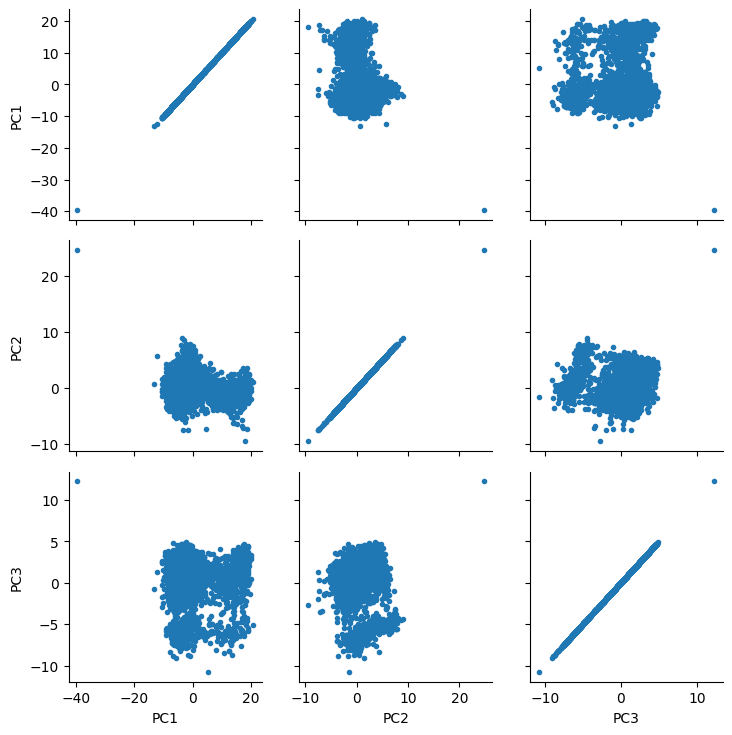

/biggin/b212/bioc1781/.local/lib/python3.10/site-packages/MDAnalysis/analysis/pca.py:321: DeprecationWarning: The `p_components` attribute was deprecated in MDAnalysis 2.0.0 and will be removed in MDAnalysis 3.0.0. Please use `results.p_components` instead.
  warnings.warn(wmsg, DeprecationWarning)
/biggin/b212/bioc1781/.local/lib/python3.10/site-packages/MDAnalysis/coordinates/PDB.py:775: UserWarning: Unit cell dimensions not found. CRYST1 record set to unitary values.
  warnings.warn("Unit cell dimensions not found. "
/biggin/b212/bioc1781/.local/lib/python3.10/site-packages/MDAnalysis/coordinates/PDB.py:1151: UserWarning: Found no information for attr: 'formalcharges' Using default value of '0'
  warnings.warn("Found no information for attr: '{}'"


In [16]:
# principal component analysis on filtered ensemble

# write a multistate pdb file for the whole ensemble so MDA will interpret it as a trajectory
with mda.Writer(base_directory + 'ensemble.pdb', u.atoms.n_atoms) as W:
    for structure in ensemble_df['structure']:
        u = mda.Universe(structure_directory + structure, 
                         structure_directory + structure)
        # renumber for consistency and to match selection token   s     
        u.atoms.residues.resids += resid_offset
        u.atoms.segments.segids = 'A'
        u.atoms.chainIDs = 'A'
        W.write(u.select_atoms(rmsd_selection))
 
# make a universe containing all the structures
u = mda.Universe(base_directory + "ensemble.pdb")

# align the ensemble to the selection token
aligner = mda.analysis.align.AlignTraj(u, u, select=rmsd_selection, in_memory=True).run()

# perform principal component analysis
pc = PCA(u, select=rmsd_selection, align=True, mean=None, n_components=None).run()

# project coorindates onto the principal components
pc_projection = pc.transform(u.select_atoms(rmsd_selection), n_components=n_pcs)

# make a dataframe to store the principal components
pca_df = pd.DataFrame(pc_projection, columns=['PC{}'.format(i+1) for i in range(n_pcs)])
pca_df['structure'] = ensemble_df.index

# print out the PCs
display(pd.DataFrame(pca_df).head())

# show table of variances explained by each PC
display(pd.DataFrame((pc.cumulated_variance*100).round(), columns=['PC cumulated variance']).head())

#drop the structure column for plotting
pca_df_pairgrid = pca_df.drop('structure', axis=1)
g = sns.PairGrid(pca_df_pairgrid)
g.map(plt.scatter, marker='.')
plt.show()
pca_df_pairgrid = None

# add principal components to the dataframe - making sure the structures are in the same order
pca_df = pca_df.sort_values(by=['structure'])
pca_df = pca_df.reset_index(drop=True)
ensemble_df['PC1'] = pca_df['PC1'].values
ensemble_df['PC2'] = pca_df['PC2'].values
ensemble_df['PC3'] = pca_df['PC3'].values

# visualisation
n_pcs = 3
for i in range(n_pcs):
    pc_n =    pc.p_components[:, i]
    trans_n =   pc_projection[:, i]
    projected = np.outer(trans_n, pc_n) + pc.mean.flatten()
    coordinates = projected.reshape(len(trans_n), -1, 3)
    
    proj_n = mda.Merge(u.select_atoms(rmsd_selection))
    proj_n.load_new(coordinates)
    
    # write this to a multistate pdb file
    with mda.Writer(base_directory + 'pca{}.pdb'.format(i+1), proj_n.atoms.n_atoms) as W:
        for ts in proj_n.trajectory:
            W.write(proj_n.atoms)

Closest to end states:


,structure,rmsd_to_outward,pDDLDT,sasa
0,msa-16-32_rank_001.pdb,0.0,91.9,104.066977
4001,ref_outward.pdb,0.0,100.0,104.066977


,structure,rmsd_to_inward,pDDLDT,sasa
1,msa-16-32_rank_002.pdb,6.945386e-07,91.2,105.067540
4000,ref_inward.pdb,4.796583e-04,100.0,105.045567


Closest to average:


,structure,rmsd_to_average,pDDLDT,sasa
0,msa-16-32_rank_001.pdb,0.180058,91.9,104.066977


Lowest 5 SASA:


,structure,rmsd_to_outward,rmsd_to_inward,pDDLDT,sasa
3,msa-16-32_rank_004.pdb,0.749821,0.774219,91.1,103.411596
88,msa-16-32_rank_089.pdb,0.376319,0.365633,89.2,103.432691
1207,msa-16-32_rank_207.pdb,0.349363,0.356919,88.5,103.467631
3345,msa-8-16_rank_345.pdb,1.076723,1.028580,84.0,103.496934
550,msa-16-32_rank_141.pdb,0.745083,0.770930,88.9,103.500372


Most different:


,structure,rmsd_to_outward,rmsd_to_inward,pDDLDT,sasa
988,msa-16-32_rank_1808.pdb,6.004069,5.950168,80.2,109.146579


/biggin/b212/bioc1781/.local/lib/python3.10/site-packages/MDAnalysis/coordinates/PDB.py:775: UserWarning: Unit cell dimensions not found. CRYST1 record set to unitary values.
  warnings.warn("Unit cell dimensions not found. "
/biggin/b212/bioc1781/.local/lib/python3.10/site-packages/MDAnalysis/coordinates/PDB.py:1151: UserWarning: Found no information for attr: 'formalcharges' Using default value of '0'
  warnings.warn("Found no information for attr: '{}'"


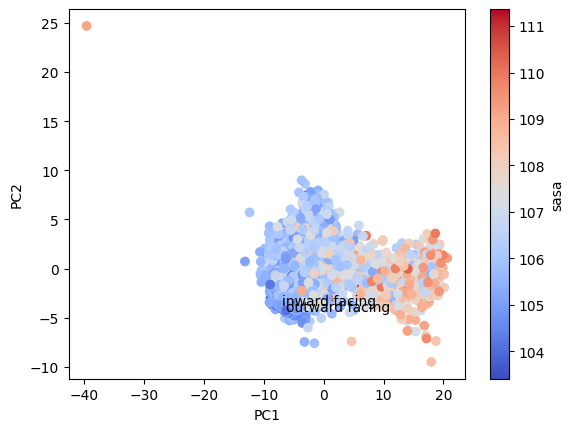

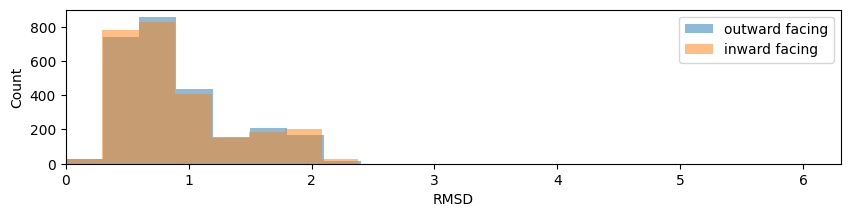

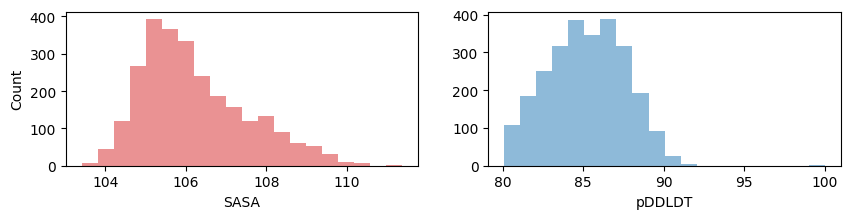

In [24]:
# trim junk structures and make plots

# tabulated results
print('Closest to end states:')
display(ensemble_df.sort_values(by=['rmsd_to_outward']).head(2)[['structure', 'rmsd_to_outward', 'pDDLDT', 'sasa']])
display(ensemble_df.sort_values(by=['rmsd_to_inward']).head(2)[['structure', 'rmsd_to_inward', 'pDDLDT', 'sasa']])
print('Closest to average:')
display(ensemble_df.sort_values(by=['rmsd_to_average']).head(1)[['structure', 'rmsd_to_average', 'pDDLDT', 'sasa']])
print('Lowest 5 SASA:')
display(ensemble_df.sort_values(by=['sasa']).head(5)[['structure', 'rmsd_to_outward', 'rmsd_to_inward', 'pDDLDT', 'sasa']])
print('Most different:')
display(ensemble_df.sort_values(by=['rmsd_mean']).tail(1)[['structure', 'rmsd_to_outward', 'rmsd_to_inward', 'pDDLDT', 'sasa']])

# write pdb of closest to average
mobile = mda.Universe(structure_directory + ensemble_df.sort_values(by=['rmsd_to_average']).head(1)['structure'].values[0], structure_directory + ensemble_df.sort_values(by=['rmsd_to_average']).head(1)['structure'].values[0], rmsd_selection=rmsd_selection)
mobile.atoms.residues.resids += resid_offset
alignto(mobile, u_outward_open, select=rmsd_selection, match_atoms=True)
writeout=mobile.select_atoms(selection_for_writeout)
writeout.atoms.write(base_directory + 'closest_to_average.pdb')

# plot 2D x = ratio_outwardness, y = sasaa, coloured by ratio_inwardness
plt.scatter(ensemble_df[plot_variable_1], ensemble_df[plot_variable_2], c=ensemble_df[plot_variable_3], cmap='coolwarm')
plt.xlabel(plot_variable_1)
plt.ylabel(plot_variable_2)
plt.colorbar(label=plot_variable_3)
plt.annotate('outward facing', (ensemble_df.loc[ensemble_df['structure'] == 'ref_outward.pdb'][plot_variable_1], ensemble_df.loc[ensemble_df['structure'] == 'ref_outward.pdb'][plot_variable_2]))
plt.annotate('inward facing', (ensemble_df.loc[ensemble_df['structure'] == 'ref_inward.pdb'][plot_variable_1], ensemble_df.loc[ensemble_df['structure'] == 'ref_inward.pdb'][plot_variable_2]))
plt.show()

# plot histogram of rmsd_to_outward and rmsd_to_inward
plt.hist(ensemble_df['rmsd_to_outward'], bins=20, alpha=0.5, label='outward facing')
plt.hist(ensemble_df['rmsd_to_inward'], bins=20, alpha=0.5, label='inward facing')
plt.legend(loc='upper right')
plt.xlabel('RMSD')
plt.ylabel('Count')
plt.xlim(0)
fig = plt.gcf()
fig.set_size_inches(10, 2)
plt.show()

# plot 2 pane histogram of SASA and pLDDT scores
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.hist(ensemble_df['sasa'], bins=20, alpha=0.5, label='sasa', color='C3')
ax1.set_xlabel('SASA')
ax1.set_ylabel('Count')
ax2.hist(ensemble_df['pDDLDT'], bins=20, alpha=0.5, label='pDDLDT')
ax2.set_xlabel('pDDLDT')
fig.set_size_inches(10, 2)
plt.show()


In [ ]:
# parallel calculation of the pairwise RMSD matrix (for the MC energy function used in the next cell)

# load backup matrix
rmsd_matrix = np.load(base_directory + 'rmsd_matrix_80_6_0_3326-strucs.npy')

# # Initialize a matrix to store pairwise RMSD values
# rmsd_matrix = np.zeros((len(ensemble_df), len(ensemble_df)))
# 
# # function to calculate RMSD values in parallel
# def calculate_rmsd(i):
# 
#     rmsd_values = []
# 
#     # setup universe for i-th structure
#     mobile = mda.Universe(structure_directory + ensemble_df['structure'].values[i], structure_directory + ensemble_df['structure'].values[i])
#     if mobile.atoms.residues.resids[0] == 1: # if first resID == one, then residues are already numbered correctly
#         mobile.atoms.residues.resids += resid_offset
# 
#     for j in range(len(ensemble_df)):
# 
#         # setup universe for j-th structure
#         ref = mda.Universe(structure_directory + ensemble_df['structure'].values[j], structure_directory + ensemble_df['structure'].values[j])
#         if ref.atoms.residues.resids[0] == 1: # if first resID == one, then residues are already numbered correctly
#             ref.atoms.residues.resids += resid_offset
# 
#         # Calculate RMSD and store it in the list
#         rmsd = alignto(mobile, ref, select=rmsd_selection, match_atoms=True)[1]
#         rmsd_values.append(rmsd)
# 
#     mobile = None       # Release memory by setting the loaded structures to None
#     ref = None
# 
#     return rmsd_values
# 
# # Perform parallel computation of RMSD values
# with Pool(processes=num_processes) as pool:
#     results = list(tqdm(pool.imap(calculate_rmsd, range(len(ensemble_df))), total=len(ensemble_df)))
# 
# # Update the rmsd_matrix with the results
# for i, rmsd_values in enumerate(results):
#     rmsd_matrix[i] = rmsd_values
# 
# results = None  # Release memory by setting the results to None
# 
# np.save(base_directory + 'rmsd_matrix.npy', rmsd_matrix)    # save the matrix (to avoid recomputing it in the future)
# 
# # Display progress information
# print('Calculation completed for', len(ensemble_df), 'pairs of structures', end='\r')

# plot the matrix
plt.imshow(rmsd_matrix, cmap='inferno')
plt.colorbar()


In [ ]:
# make a matrix of pairwise SASA differences
sasa_matrix = np.zeros((len(ensemble_df), len(ensemble_df)))
n_elements = len(ensemble_df) * len(ensemble_df)

# all pairwise sasas (these can just be subtracted from eachother)
for i in range(len(ensemble_df)):
    for j in range(len(ensemble_df)):
        sasa_matrix[i,j] = (ensemble_df['sasa'].iloc[i] - ensemble_df['sasa'].iloc[j])
        #sasa_matrix[i,j] = (ensemble_df['sasa'][i] - ensemble_df['sasa'][j])

# show the matrix
plt.imshow(sasa_matrix, cmap='coolwarm')
plt.colorbar()


In [ ]:
# make a matrix of differences in collective variable between structures
cv_matrix = np.zeros((len(ensemble_df), len(ensemble_df)))
n_elements = len(ensemble_df) * len(ensemble_df)

# all pairwise difference in collective variable (these can just be subtracted from eachother)
for i in range(len(ensemble_df)):
    for j in range(len(ensemble_df)):
        cv_matrix[i,j] = (ensemble_df[collective_variable].iloc[i] - ensemble_df[collective_variable].iloc[j])
        #cv_matrix[i,j] = (ensemble_df[collective_variable][i] - ensemble_df[collective_variable][j])

# show the matrix
plt.imshow(cv_matrix, cmap='coolwarm')
plt.colorbar()



In [ ]:
# "intertial" sasa relaxation

n_max_steps = 100000
max_num_rejections = 1000
temperature = 1

def calc_sasa_energy(new_structure, current_structure):

    wf_rmsd = 5
    # get the difference in rmsd from the rmsd_matrix
    energy_rmsd = 0
    energy_rmsd = wf_rmsd * np.sqrt(rmsd_matrix[np.where(ensemble_df.index.values == new_structure)[0][0], np.where(ensemble_df.index.values == current_structure)[0][0]]**2)

    wf_collective_variable = 0
    # get the difference in collective variable from the cv_matrix
    energy_collective_variable = 0
    energy_collective_variable = wf_collective_variable * np.sqrt(cv_matrix[np.where(ensemble_df.index.values == new_structure)[0][0], np.where(ensemble_df.index.values == current_structure)[0][0]]**2)

    wf_sasa = 1
    # for miminising sasa
    energy_sasa = 0
    energy_sasa = -1 * wf_sasa * sasa_matrix[np.where(ensemble_df.index.values == new_structure)[0][0], np.where(ensemble_df.index.values == current_structure)[0][0]]

    # final term is sum
    energy = energy_rmsd + energy_sasa + energy_collective_variable

    # final energy
    return energy

# function to rnadomly wawlk through the ensemble and return a path
def mc_sasa_minimisation(seed):
    
    # random seed
    np.random.seed(seed)

    mcpath = []    
    num_rejections = 0

    # starting structure is a random structure from the ensemble
    #starting_structure = ensemble_df.sample(1).index.values[0]
    
    # starting structure is the outward facing reference structure (index)
    starting_structure = ensemble_df.loc[ensemble_df['structure'] == 'ref_outward.pdb'].index.values[0]

    # structure pool consists of the names of the structures in the ensemble dataframe
    structure_pool = ensemble_df.index.values

    # add the starting structure to the path
    mcpath.append(starting_structure)

    # remove the starting structure from the pool
    structure_pool = np.delete(structure_pool, np.where(structure_pool == starting_structure)[0][0])

    current_structure = starting_structure

    # loop indefinitely (until n_max_steps is reached)
    #for i in range(n_max_steps):

    #loop until num_rejections > max_num_rejections
    while num_rejections < max_num_rejections:
            
        ## calculate energy of current path
       # energy = calc_sasa_energy(mcpath)

        # select a random structure from the pool (and then remove it from the pool later if it is accepted)
        random_structure_in_pool = np.random.choice(structure_pool)

        # calcualte energy of proposed path
        delta_energy = calc_sasa_energy(current_structure, random_structure_in_pool)

        # metropolis criterion
    
        # if lower, accept the new path
        if delta_energy < 0:

            current_structure = random_structure_in_pool
            mcpath.append(current_structure)

            num_rejections = 0
            #print(delta_energy)

        else:

            # if higher, accept with probability e^(-difference/temp)
            if np.random.rand() < np.exp(-delta_energy / temperature):

                current_structure = random_structure_in_pool
                mcpath.append(current_structure)

                num_rejections = 0
                #print(delta_energy)

            else:

                # increment a counter for the number of times the path is rejected
                num_rejections += 1
                mcpath.append(current_structure)
                pass

    return mcpath

# call the function
sasa_min_path = mc_sasa_minimisation(0)

# plot the path on the 2D plot
plt.scatter(ensemble_df[plot_variable_1], ensemble_df[plot_variable_2], c=ensemble_df[plot_variable_3], cmap='coolwarm')
plt.xlabel(plot_variable_1)
plt.ylabel(plot_variable_2)
plt.colorbar(label=plot_variable_3)
plt.annotate('outward facing', (ensemble_df.loc[ensemble_df['structure'] == 'ref_outward.pdb'][plot_variable_1], ensemble_df.loc[ensemble_df['structure'] == 'ref_outward.pdb'][plot_variable_2]))
plt.annotate('inward facing', (ensemble_df.loc[ensemble_df['structure'] == 'ref_inward.pdb'][plot_variable_1], ensemble_df.loc[ensemble_df['structure'] == 'ref_inward.pdb'][plot_variable_2]))
plt.plot(ensemble_df[plot_variable_1].loc[sasa_min_path], ensemble_df[plot_variable_2].loc[sasa_min_path], c='black')

# annotate the most common structure in the path
plt.annotate('most common structure', (ensemble_df[plot_variable_1].loc[sasa_min_path].value_counts().index[0], ensemble_df[plot_variable_2].loc[sasa_min_path].value_counts().index[0]))
# get the name of this structure 
most_common_structure = ensemble_df[plot_variable_1].loc[sasa_min_path].value_counts().index[0]
print('Most common structure:', ensemble_df.loc[ensemble_df[plot_variable_1] == most_common_structure]['structure'].values[0])

# plot a bar chart of frequency of the top 5 structures in the path
plt.figure()
# get the top 5 structures
top_5 = ensemble_df[plot_variable_1].loc[sasa_min_path].value_counts().index[:5]
# plot the bar chart
plt.bar(ensemble_df.loc[ensemble_df[plot_variable_1].isin(top_5)]['structure'], ensemble_df[plot_variable_1].loc[sasa_min_path].value_counts().values[:5])
plt.xticks(rotation=90)
plt.ylabel('Frequency')
plt.show()

            

In [ ]:
# assign bins for binned mc path finding

# assign bins such that there are an equal number of structures in each bin
bins = np.zeros(mc_n_bins)
for i in range(mc_n_bins):
    bins[i] = ensemble_df[collective_variable].quantile((i+1)/mc_n_bins)

# assign bins that are evenly spaced in the collective variable
# TO DO

# add a column to the dataframe with the bin number
ensemble_df['bin'] = np.digitize(ensemble_df[collective_variable], bins)

# assign bin=NAN to all structures with variable > threshold
#ensemble_df.loc[ensemble_df['PC2'] < 2.5, 'bin'] = np.nan

# plot number of structures per bin
plt.hist(ensemble_df['bin'], bins=mc_n_bins)
plt.show()

# print any bins that are empty
print('Empty Bins:')
for i in range(mc_n_bins-2):
    if i not in ensemble_df['bin'].values:
        print(i)
    
# show bin distribution
plt.scatter(ensemble_df[plot_variable_1], ensemble_df[plot_variable_2], c=ensemble_df['bin'], cmap='tab20c')
plt.colorbar()
# plot the initial guesses
#for i in range(mc_n_bins-2):
#    plt.scatter(ensemble_df.loc[ensemble_df['structure'] == initial_guesses[i]][plot_variable_1], ensemble_df.loc[ensemble_df['structure'] == initial_guesses[i]][plot_variable_2], marker='x', color='black')
plt.show()


In [ ]:
# binned MC path finding in parallel

# define a function that runs binned monte carlo path finding
def binned_mc_path_finding(mc_run):

    if start_from_endstates == True:
        # starting structure is one of the end states
        starting_structure = ensemble_df.sort_values(by=['rmsd_to_outward']).head(1).index.values[0]
        #starting_structure = ensemble_df.sort_values(by=['rmsd_to_inward']).head(1).index.values[0]
    else:
        # starting structure is a random structure from the first bin
        starting_structure = np.random.choice(ensemble_df[ensemble_df['bin'] == 0].index.values)
    
    starting_bin = 0

    temperature = mc_temp
    wf_sasa = mc_wf_sasa
    n_bins = mc_n_bins

    mcpath = []    
    mcpath.append(starting_structure)
    current_path_length = len(mcpath)

    # while the current structure is not in bin n_bins
    current_structure = starting_structure
    next_bin = starting_bin+1
    while next_bin != n_bins:

        # the energy proxy is the sum of the square rmsd between each structure in the path
        energy = 0
        for i in range(len(mcpath) - 1):
            energy += np.sqrt ( 1/current_path_length * (rmsd_matrix[np.where(ensemble_df.index.values == mcpath[i])[0][0], np.where(ensemble_df.index.values == mcpath[i+1])[0][0]]**2) )
            energy += sasa_matrix[np.where(ensemble_df.index.values == mcpath[i])[0][0], np.where(ensemble_df.index.values == mcpath[i+1])[0][0]]*wf_sasa

        # propose a move by selecting a random non-self structure from the pool
        structure_pool = ensemble_df[ensemble_df['bin'] == next_bin].index.values
        proposed_structure = np.random.choice(structure_pool[structure_pool != current_structure])

        # proposed path
        new_mcpath = mcpath.copy()
        new_mcpath.append(proposed_structure)

        # calcualte energy of proposed path
        new_energy = 0
        for i in range(len(new_mcpath) - 1):
            new_energy += np.sqrt ( 1/current_path_length * (rmsd_matrix[np.where(ensemble_df.index.values == new_mcpath[i])[0][0], np.where(ensemble_df.index.values == new_mcpath[i+1])[0][0]]**2) )
            new_energy += sasa_matrix[np.where(ensemble_df.index.values == new_mcpath[i])[0][0], np.where(ensemble_df.index.values == new_mcpath[i+1])[0][0]]*wf_sasa

        # calculate the difference between the two energies
        delta_energy = new_energy - energy

        # metropolis criterion
        if delta_energy < 0:
            current_structure = proposed_structure
            mcpath.append(current_structure)
            # if the proposed structure is in the next bin, increment next_bin
            if ensemble_df.loc[proposed_structure]['bin'] == next_bin:
                next_bin += 1
        # if higher, accept with probability e^(-difference/temp)
        else:
            if np.random.rand() < np.exp(-delta_energy / temperature):
                current_structure = proposed_structure
                mcpath.append(current_structure)
                # if the proposed structure is in the next bin, increment next_bin
                if ensemble_df.loc[proposed_structure]['bin'] == next_bin:
                    next_bin += 1
            else:
                pass

    # calculate the energy of the final path
    energy = 0
    for i in range(len(mcpath) - 1):
        energy += np.sqrt ( 1/current_path_length * (rmsd_matrix[np.where(ensemble_df.index.values == mcpath[i])[0][0], np.where(ensemble_df.index.values == mcpath[i+1])[0][0]]**2) )
        energy += sasa_matrix[np.where(ensemble_df.index.values == mcpath[i])[0][0], np.where(ensemble_df.index.values == mcpath[i+1])[0][0]]*wf_sasa

    #  replace mcpath entries (which are indices of hte dataframe) with the structure names from the 'structure' column
    #mcpath = ensemble_df.loc[mcpath]['structure'].values
    return [energy, mcpath, ensemble_df.loc[mcpath]['structure'].values]

mc_runs = []

# run once
mcruns_initial = binned_mc_path_finding(1)

# get the structure indices
print(mcruns_initial[1])
# drop the frist and last structures
mcruns_initial = mcruns_initial[1][1:-1]


#
## run mc_n_bins runs in parallel
#with Pool(processes=num_processes) as pool:
#    mc_runs = list(tqdm(pool.imap(binned_mc_path_finding, range(mc_n_runs)), total=mc_n_runs))
#
## turn this mc_runs list object into a pandas dataframe
#mc_runs_df = pd.DataFrame(mc_runs, columns=['energy', 'path', 'path structures'])
#mc_runs_df = mc_runs_df.sort_values(by=['energy'])
#
## write out the best run to a multistate pdb file and append timestamp to filename
#with mda.Writer(base_directory + 'best_run.pdb', u.atoms.n_atoms) as W:
#    # get the structures of the lowest energy path
#    for structure in mc_runs_df.head(1)['path structures'].values[0]:
#        # if structure is the reference, dont renumber residues
#        if structure == 'ref_outward.pdb' or structure == 'ref_inward.pdb':
#            # use a non-reference structure to make the universe
#            u = mda.Universe(structure_directory + structure, 
#                             structure_directory + structure) # make universe
#            u.atoms.residues.resids += resid_offset 
#            u.atoms.segments.segids = 'A'
#            u.atoms.chainIDs = 'A'
#            W.write(u.select_atoms('protein'))
#        else:
#            u = mda.Universe(structure_directory + structure, 
#                             structure_directory + structure) # make universe
#            u.atoms.residues.resids += resid_offset
#            W.write(u.select_atoms('protein'))
        

In [ ]:
# MC path finding by exchanging structures in a path of length N

def calc_energy(path, path_length):

    wf_rmsd = 1
    # for minimising rmsd between structures on path
    energy_rmsd = 0
    for i in range(path_length - 1):
        energy_rmsd += (rmsd_matrix[np.where(ensemble_df.index.values == path[i])[0][0], np.where(ensemble_df.index.values == path[i+1])[0][0]]**2)
    energy_rmsd = wf_rmsd * np.sqrt ( 1/path_length * energy_rmsd )

    wf_cv = 1
    # for minimising pairwise differences in collective variable between structures on path
    energy_cv = 0
    for i in range(path_length -1):
        energy_cv += (cv_matrix[np.where(ensemble_df.index.values == path[i])[0][0], np.where(ensemble_df.index.values == path[i+1])[0][0]]**2)
    energy_cv = wf_cv * np.sqrt ( 1/path_length * energy_cv )

    # final term is sum
    energy = energy_rmsd + energy_cv

    # final energy
    return energy

# define a function that runs monte carlo simulated annealing to optimise path smoothness
def mc_path_optimisation(seed):
    
    # random seed
    np.random.seed(seed)

    mc_n_steps=10000
    initial_temperature = 0.000001

    # list of temperatures mapped to mc_n_steps increasing stepwise in 10 increments
    final_temperature = initial_temperature*1000
    temperatures = np.logspace(np.log10(initial_temperature), np.log10(final_temperature), num=mc_n_steps)

    wf_sasa = mc_wf_sasa
    mc_path_length = mc_n_bins

    mcpath = []

    # end states are the reference structures (get the index of the reference structures in the dataframe)
    first_structure = 'ref_outward.pdb'
    last_structure = 'ref_inward.pdb'

    first_structure = ensemble_df.index.values[np.where(ensemble_df['structure'] == first_structure)[0][0]]
    last_structure = ensemble_df.index.values[np.where(ensemble_df['structure'] == last_structure)[0][0]]

    # structure pool consists of the names of the structures in the ensemble dataframe
    structure_pool = ensemble_df.index.values

    # remove the first and last structures from the pool
    structure_pool = structure_pool[structure_pool != first_structure]
    structure_pool = structure_pool[structure_pool != last_structure]

    # randomly sample structures from each bin (excluding the first and last bins becasue they are the end states) for an initial guess path
    initial_guess_indices = []
    for i in range(mc_n_bins-2):
        initial_guess = ensemble_df.loc[ensemble_df['bin'] == i+1].sample(1)
        initial_guess_indices.append(initial_guess.index[0])

    # add the end states to the initial guess path
    mcpath = np.concatenate((np.array([first_structure]), initial_guess_indices, np.array([last_structure])))

    # remove the randomly selected initial structures from the pool
    structure_pool = structure_pool[np.isin(structure_pool, mcpath[1:-1], invert=True)]

    # dictionary of paths and energies
    path_energies = {}

    # length of structure pool
    n_structure_pool = len(structure_pool)

    # run n_mc_runs steps
    for i in range(mc_n_steps):

        temperature = temperatures[i]

        # calculate energy of current path
        energy = calc_energy(mcpath, mc_path_length)
        
        # propose an exchange of a random (not endstate) structure in the path with a random structure from the pool
        new_mcpath = mcpath.copy()

        # select a random structure from the path that is not an endstate
        random_structure_in_path = np.random.choice(new_mcpath[1:-1])

        # select a random structure from the pool (and then remove it from the pool later if it is accepted)
        random_structure_in_pool = np.random.choice(structure_pool)

        # replace the random structure in the new path with the random structure from the pool
        new_mcpath[np.where(new_mcpath == random_structure_in_path)[0][0]] = random_structure_in_pool

        # calcualte energy of proposed path
        new_energy = calc_energy(new_mcpath, mc_path_length)

        # calculate the difference between the two energies
        delta_energy = 0
        delta_energy = new_energy - energy

        # metropolis criterion
    
        # if lower, accept the new path
        if delta_energy < 0:

            mcpath = new_mcpath

            # Insert the structure that was replaced into the middle of the structure pool (so the end states are always at the ends of the pool)
            structure_pool = np.insert(structure_pool, len(structure_pool) // 2, random_structure_in_path)
            # Remove the structure that was added to the path from the pool
            structure_pool = structure_pool[structure_pool != random_structure_in_pool]

            path_energies[new_energy] = mcpath
        
        else:

            # if higher, accept with probability e^(-difference/temp)
            if np.random.rand() < np.exp(-delta_energy / temperature):

                mcpath = new_mcpath

                # Insert the structure that was replaced into the middle of the structure pool (so the end states are always at the ends of the pool)
                structure_pool = np.insert(structure_pool, len(structure_pool) // 2, random_structure_in_path)
                # Remove the structure that was added to the path from the pool
                structure_pool = structure_pool[structure_pool != random_structure_in_pool]

                path_energies[new_energy] = mcpath

            else:
                pass

        # check the structure pool is the correct length
        if len(structure_pool) != n_structure_pool:
            raise ValueError('Error: structure pool is the wrong length')
            
    # get the path with the lowest energy
    final_energy = min(path_energies.keys())
    final_path = path_energies[final_energy]
    relaxation_energies = list(path_energies.keys())
    final_path_structures = tuple(ensemble_df.loc[final_path]['structure'].values)

    return [final_energy, final_path, final_path_structures, relaxation_energies]

mc_n_runs = 1000

# run mc_n_bins runs in parallel
with Pool(processes=num_processes) as pool:
    mc_runs = list(tqdm(pool.imap(mc_path_optimisation, range(mc_n_runs)), total=mc_n_runs))

# add the final energies and final path structures to a dataframe
mc_runs_df = pd.DataFrame(mc_runs, columns=['energy', 'path', 'path structures', 'relaxation energies'])
mc_runs_df = mc_runs_df.sort_values(by=['energy']) 

# display the best run
display(mc_runs_df[['energy', 'path structures']].head(3))

# plot relaxation of the best run
for i in range(1, 4):
    plt.plot(mc_runs_df.iloc[i]['relaxation energies'])
plt.show()

# calculate the energy for each point in the best path (mc_runs[1]) (for plotting)
energy_over_path = []
energy = {}
# get hte "path" of the best run (in indices)
test = mc_runs_df.iloc[1]['path']
for i in range(mc_n_bins - 1):
        energy[i] = (rmsd_matrix[np.where(ensemble_df.index.values == test[i])[0][0], np.where(ensemble_df.index.values == test[i+1])[0][0]]**2)
        energy[i] = np.sqrt ( 1 * energy[i] )
plt.plot(energy.values(), label='best')

test = mc_runs_df.iloc[-1]['path']
for i in range(mc_n_bins - 1):
        energy[i] = (rmsd_matrix[np.where(ensemble_df.index.values == test[i])[0][0], np.where(ensemble_df.index.values == test[i+1])[0][0]]**2)
        energy[i] = np.sqrt ( 1 * energy[i] )
plt.plot(energy.values(), label='worst')
# plot energy

# plot energy
plt.legend()
plt.show()

# write out the best run to a multistate pdb file and append timestamp to filename
with mda.Writer(base_directory + 'best_run.pdb', u.atoms.n_atoms) as W:
    # get the structures of the lowest energy path
    for structure in mc_runs_df.head(1)['path structures'].values[0]:
        # if structure is the reference, dont renumber residues
        if structure == 'ref_outward.pdb' or structure == 'ref_inward.pdb':
            # use a non-reference structure to make the universe
            u = mda.Universe(structure_directory + structure, 
                             structure_directory + structure) # make universe
            u.atoms.residues.resids += resid_offset 
            u.atoms.segments.segids = 'A'
            u.atoms.chainIDs = 'A'
            W.write(u.select_atoms('protein'))
        else:
            u = mda.Universe(structure_directory + structure, 
                             structure_directory + structure) # make universe
            u.atoms.residues.resids += resid_offset
            W.write(u.select_atoms('protein'))
        

In [ ]:
# plot the best path

# plot all the structures
plt.scatter(ensemble_df[plot_variable_1], ensemble_df[plot_variable_2], c=ensemble_df['bin'], cmap='tab20c', alpha=0.8)

# for each structure in best run, plot the rmsd to outward and inward from the ensemble_df dataframe
for structure in mc_runs_df.head(1)['path'].values[0]:
    plt.scatter(ensemble_df.loc[structure][plot_variable_1], ensemble_df.loc[structure][plot_variable_2], c='black')
    #plt.annotate(structure, (ensemble_df.loc[structure][plot_variable_1], ensemble_df.loc[structure][plot_variable_2]))   
    #plt.annotate(ensemble_df.loc[structure]['structure'], (ensemble_df.loc[structure][plot_variable_1], ensemble_df.loc[structure][plot_variable_2]), xytext=(ensemble_df.loc[structure][plot_variable_1], ensemble_df.loc[structure][plot_variable_2]+0.5), ha='center', va='bottom', arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0.2'))

# draw connecting lines
for i in range(len(mc_runs_df.head(1)['path'].values[0]) - 1):
    # get the rmsd to outward and inward from ensemble_df
    x1 = ensemble_df.loc[mc_runs_df.head(1)['path'].values[0][i]][plot_variable_1]
    y1 = ensemble_df.loc[mc_runs_df.head(1)['path'].values[0][i]][plot_variable_2]
    x2 = ensemble_df.loc[mc_runs_df.head(1)['path'].values[0][i+1]][plot_variable_1]
    y2 = ensemble_df.loc[mc_runs_df.head(1)['path'].values[0][i+1]][plot_variable_2]
    plt.plot([x1, x2], [y1, y2], c='black', alpha=0.6, linestyle='dashed')

plt.xlabel(plot_variable_1)
plt.ylabel(plot_variable_2)
plt.show()

# plot SASA
for structure in mc_runs_df.head(1)['path'].values[0]:
    # plot rmsd to each end state on x and y axis and colour by sasa
    plt.scatter(ensemble_df.loc[structure]['rmsd_to_outward'], ensemble_df.loc[structure]['rmsd_to_inward'], c=ensemble_df.loc[structure]['sasa'], cmap='coolwarm')
#labels
plt.xlabel('rmsd_to_outward')
plt.ylabel('rmsd_to_inward')
#plt.ylim(ensemble_df['rmsd_ratio_outwardness'].min(), ensemble_df['rmsd_ratio_outwardness'].max())
fig = plt.gcf()
#fig.set_size_inches(15, 2)
plt.xticks(rotation=90)
plt.show()

print('Best Run:')
mc_runs_df.head(1)


In [ ]:
# run propka
from propkatraj import PropkaTraj

residues = ['205', '305']
# copy dataframe 
pka_df = ensemble_df




## write a multistate pdb file for the whole ensemble so MDA will interpret it as a trajectory
#with mda.Writer(base_directory + 'ensemble.pdb', u.atoms.n_atoms) as W:
#    for structure in ensemble_df['structure']:
#        u = mda.Universe(structure_directory + structure, 
#                         structure_directory + structure)
#        # renumber for consistency and to match selection token   s     
#        u.atoms.residues.resids += resid_offset
#        u.atoms.segments.segids = 'A'
#        u.atoms.chainIDs = 'A'
#        W.write(u.select_atoms(rmsd_selection))
 
 ## make a universe containing all the structures
 #u = mda.Universe(base_directory + "ensemble.pdb")
 #
 #u.atoms.residues.resids += resid_offset
 #u.atoms.segments.segids = 'A'
 #u.atoms.chainIDs = 'A'
 #
 #pkatraj = PropkaTraj(u, select='protein', skip_failure=True, Verbose=True)
 #pkatraj.run()   # creates a pandas dataframe with the pka values for each residue in each frame results.pkas
 #struc_pkas = pkatraj.results.pkas.describe()

# align the ensemble to the selection token
#aligner = mda.analysis.align.AlignTraj(u, u, select=rmsd_selection, in_memory=True).run()




# make a universe object containing all the structures
#u = mda.Universe(structure_directory + structures[0], structure_directory + structures[0])

# loop thorugh the structures making a universe object for each
print(structures[1:])
for structure in structures[1:]:
    u = mda.Universe(structure_directory + structure, structure_directory + structure)
    # renumber residues
    u.atoms.residues.resids += resid_offset
    u.atoms.segments.segids = 'A'
    u.atoms.chainIDs = 'A'

    #print(structure)
    pkatraj = PropkaTraj(u, select='protein', skip_failure=True, Verbose=True)
    pkatraj.run()   # creates a pandas dataframe with the pka values for each residue in each frame results.pkas
    print(pkatraj.results.pkas)
    struc_pkas = pkatraj.results.pkas.describe()
  
  #for residue in residues:
  #    # get the mean pka for the residue of interest
  #    pka = struc_pkas.loc['mean', residue]
  #    # add this pka value to a column labelled residue in the pka_df with the structure name as the index 
  #    pka_df.loc[structure, 'pka_' + str(residue)] = pka
        